<a href="https://colab.research.google.com/github/jsqihui/fastai/blob/main/bear_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

初始化fastbook lib，mounted的地址有点让人疑惑

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 5.5MB/s 
     |████████████████████████████████| 1.1MB 24.2MB/s 
     |████████████████████████████████| 194kB 41.0MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
import os
# os.mkdir('images')
key = os.environ.get('AZURE_SEARCH_KEY', '3dd93d161d4f476194ead03ba16ae2c6')
bear_types = 'grizzly','black','teddy'
path = Path('bears')
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

* key就是Azure的search key，好像有限制，每三秒一次query，每次返回150这样
* path是Path object，一个很好用的当前路径的wrapper，Path('bears')的意思就是说在当前路径的根目录下，创建bears的directory
(path/'black') 表示创建一个Path object的subdir
* results储存了用bing key search出的150张图的url, f'{}'表示python里的string format的function
* download_images用来下载相应的url

In [4]:
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)
fns

(#416) [Path('bears/grizzly/00000120.jpg'),Path('bears/grizzly/00000003.jpg'),Path('bears/grizzly/00000073.jpg'),Path('bears/grizzly/00000032.png'),Path('bears/grizzly/00000137.jpg'),Path('bears/grizzly/00000017.jpg'),Path('bears/grizzly/00000127.jpg'),Path('bears/grizzly/00000122.jpg'),Path('bears/grizzly/00000034.jpg'),Path('bears/grizzly/00000046.jpg')...]

fns存了所有的image，failed是用来检查是否每一个image都是正确的格式，最后如果不正确就用Path.unlink来删除。

* 其实这一步就是检查image的错误，fns不会再之后用到

In [5]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [38]:
dls = bears.dataloaders(path)

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

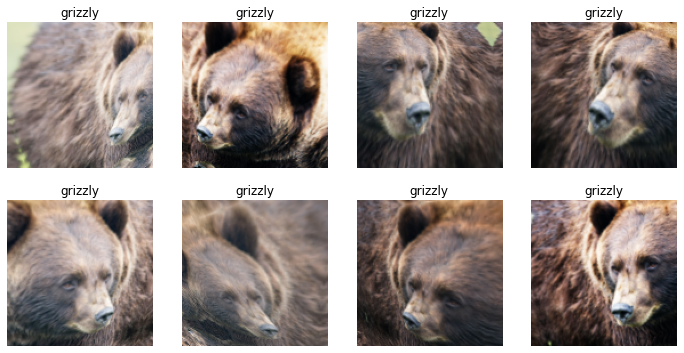

In [39]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

对于已有图像进行resize和augment，直接用函数就行，非常方便

In [6]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [7]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.512394,0.587363,0.175000,00:14


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.615309,0.448471,0.112500,00:15
1,0.461928,0.530087,0.125000,00:14
2,0.398641,0.520664,0.100000,00:14
3,0.378269,0.491802,0.112500,00:15


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency e

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


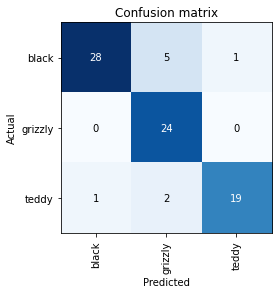

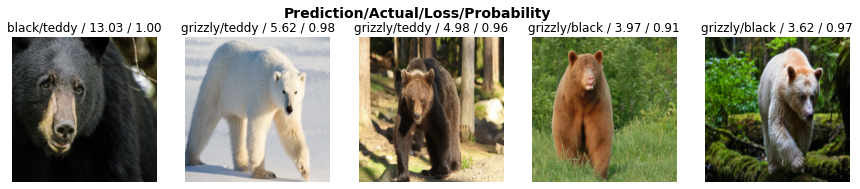

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=1)